In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from pca import PCA
from kmeans import KMeans
import os

In [20]:
df = pd.read_csv("data/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [22]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [23]:
print(df['Gender'].unique())
df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})
print(df['Gender'].unique())

['Male' 'Female']
[0 1]


In [24]:
#Preprocessing
X = df[['Gender','Age','Annual Income (k$)','Spending Score (1-100)']].values

In [36]:
OUT_DIR = "output"

In [37]:
#PCA
pca = PCA(n_components=2)
pca.fit(X)
print(pca.components)
X_reduced = pca.transform(X)

[[ 3.32728191e-04 -1.57871198e-03]
 [-1.88977291e-01  1.30961404e-01]
 [ 5.88622756e-01  8.08388308e-01]
 [ 7.86009366e-01 -5.73894557e-01]]


In [38]:
#KMeans
kmeans = KMeans(k=4)
kmeans.fit(X_reduced)
labels = kmeans.labels

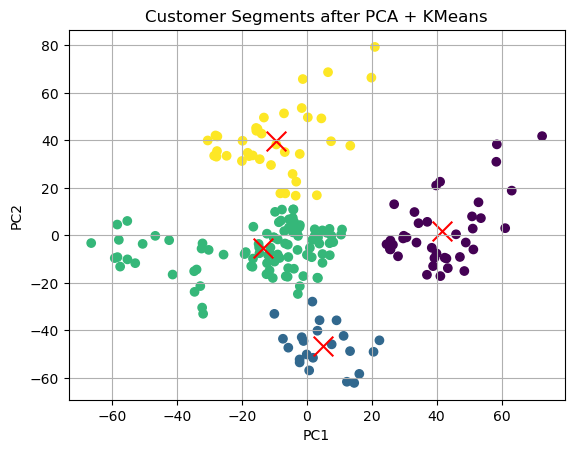

In [39]:
# Plot results
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x', s=200)
plt.title("Customer Segments after PCA + KMeans")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [40]:
def compute_wcss(X, labels, centroids):
    wcss = 0
    for i in range(centroids.shape[0]):
        cluster_points = X[labels == i]
        wcss += np.sum((cluster_points - centroids[i]) ** 2)
    return wcss

# Compute metrics
wcss = compute_wcss(X_reduced, labels, kmeans.centroids)
sil_score = silhouette_score(X_reduced, labels)

print(f"WCSS: {wcss:.2f}")
print(f"Silhouette Score: {sil_score:.2f}")

WCSS: 74701.15
Silhouette Score: 0.49


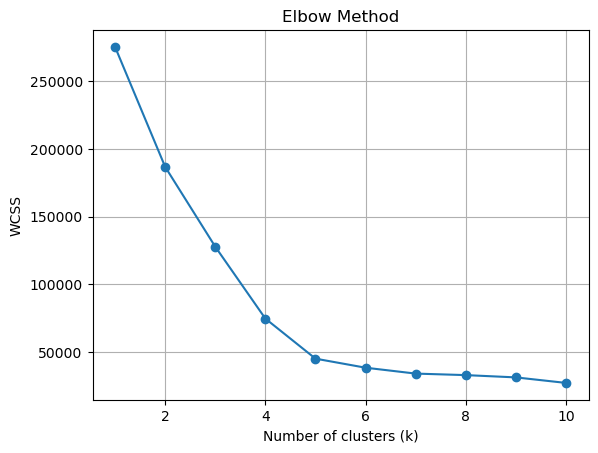

In [41]:
wcss_values = []

for k in range(1, 11):
    km = KMeans(k=k)
    km.fit(X_reduced)
    wcss_values.append(compute_wcss(X_reduced, km.labels, km.centroids))

plt.plot(range(1, 11), wcss_values, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

In [42]:
final_k = 4
km_final = KMeans(k=final_k)
km_final.fit(X_reduced)
labels_final = km_final.labels
centroids_final = np.array(km_final.centroids)

In [62]:
df['Cluster'] = labels_final
print("Assigned clusters with k={} (counts):".format(final_k))
print(df['Cluster'].unique())
print(df['Cluster'].value_counts().sort_index())

Assigned clusters with k=4 (counts):
[2 1 0 3]
Cluster
0     39
1     22
2    101
3     38
Name: count, dtype: int64


In [64]:
#Cluster Profiling
profile_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
cluster_profile = df.groupby('Cluster')[profile_cols].agg(['mean','median','count'])
print(cluster_profile.columns.values)
# flatten columns
cluster_profile.columns = ['_'.join(col).strip() for col in cluster_profile.columns.values]
cluster_profile = cluster_profile.reset_index()
print("\nCluster profile (mean/median/count):")
print(cluster_profile)

[('Age', 'mean') ('Age', 'median') ('Age', 'count')
 ('Annual Income (k$)', 'mean') ('Annual Income (k$)', 'median')
 ('Annual Income (k$)', 'count') ('Spending Score (1-100)', 'mean')
 ('Spending Score (1-100)', 'median') ('Spending Score (1-100)', 'count')]

Cluster profile (mean/median/count):
   Cluster   Age_mean  Age_median  Age_count  Annual Income (k$)_mean  \
0        0  32.692308        32.0         39                86.538462   
1        1  25.272727        23.5         22                25.727273   
2        2  43.603960        47.0        101                48.168317   
3        3  40.394737        41.5         38                87.000000   

   Annual Income (k$)_median  Annual Income (k$)_count  \
0                       79.0                        39   
1                       24.5                        22   
2                       50.0                       101   
3                       80.0                        38   

   Spending Score (1-100)_mean  Spending Scor

In [50]:
# ------------------------
# 7. Visualize clusters in PCA space
# ------------------------
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels_final, cmap='tab10', s=50, alpha=0.8)
plt.scatter(centroids_final[:,0], centroids_final[:,1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA projection colored by Cluster (k={final_k})")
plt.legend(*scatter.legend_elements(), title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "clusters.png"))
plt.close()
print(f"Cluster scatter saved to {OUT_DIR}/clusters.png")

Cluster scatter saved to output/clusters.png


In [52]:
# ------------------------
# 8. Produce simple marketing personas (automated heuristics)
# ------------------------
def persona_from_profile(row):
    age = row['Age_mean']
    income = row['Annual Income (k$)_mean']
    spend = row['Spending Score (1-100)_mean']

    # Simple rules to name personas
    if income >= df['Annual Income (k$)'].quantile(0.75) and spend >= df['Spending Score (1-100)'].quantile(0.75):
        return "Affluent High Spenders"
    if income >= df['Annual Income (k$)'].quantile(0.75) and spend < df['Spending Score (1-100)'].quantile(0.5):
        return "Affluent Low-Spenders"
    if spend >= df['Spending Score (1-100)'].quantile(0.75):
        return "High Engagement Shoppers"
    if income < df['Annual Income (k$)'].quantile(0.5) and spend < df['Spending Score (1-100)'].quantile(0.5):
        return "Budget-conscious"
    return "Core Customers"

cluster_profile['Persona'] = cluster_profile.apply(persona_from_profile, axis=1)
cluster_profile.to_csv(os.path.join(OUT_DIR, "cluster_profile_with_persona.csv"), index=False)
print(f"Cluster personas saved to {OUT_DIR}/cluster_profile_with_persona.csv")

Cluster personas saved to output/cluster_profile_with_persona.csv
